In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DateType, TimestampType
import datetime
from pandas_datareader import data
from bokeh.plotting import figure, show, output_file
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

In [2]:
SPARK_MASTER = "spark://master:7077"
HDFS_MASTER = "hdfs://master:9000/"

time = 60 # minute

In [3]:
conf = SparkConf()\
    .set("spark.executor.memory", "2g")\
    .set("spark.executor.core", "2")\
    .setAppName("VISUALINE")\
    .setMaster(SPARK_MASTER)

sparkSession = SparkSession.builder.config(conf = conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/12 07:20:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
@udf(returnType=TimestampType())
def convert_time(x):
    try:
        return datetime.datetime.fromtimestamp(int(int(x)/1000))
    except:
        return None
    return None

@udf(returnType=StringType())
def group_t(x):
    try:
        day = x.day
        month = x.month
        year = x.year
        hour = x.hour
        m = x.minute
        m_new = time*(m // time + 1)
        time_delta = m_new - m
        return str(x + datetime.timedelta(minutes = time_delta, seconds = (x.second)*-1))
    except:
        return None

In [5]:
df = sparkSession.read\
    .option("inferSchema","true")\
    .csv(HDFS_MASTER + "/data/hdfs/example/1st/*")\
    .toDF("event_type", "event_time", "symbol", "kline_start_time", 
         "kline_close_time", "k_symbol", "internal", "first_trade_id", 
         "last_trade_id", "open_price", "close_price", "high_price", "low_price", 
         "base_asset_volume", "number_of_trades", "is_this_kline_closed",
        "quote_asset_volume", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore")\
    .withColumn("event_time", convert_time(F.col("event_time")).cast(TimestampType()))

In [6]:
df = df.withColumn("Status", F.when(F.col("close_price") > F.col("open_price"), "Increase")
                         .when(F.col("close_price") < F.col("open_price"), "Decrease")
                         .otherwise("Equal")
             )\
        .withColumn("Middle", (F.col("open_price") + F.col("close_price"))/2)\
        .withColumn("Height", F.abs(F.col("open_price") -  F.col("close_price")))\
        .withColumn("group_event_time", group_t(F.col("event_time")))\
        .withColumn("index_open", F.row_number().over(Window.partitionBy("group_event_time").orderBy(F.col("event_time").asc())))\
        .withColumn("index_close", F.row_number().over(Window.partitionBy("group_event_time").orderBy(F.col("event_time").desc())))\
        .groupby("group_event_time").agg(
            F.max(F.col("high_price")).alias("high_price"),
            F.min(F.col("low_price")).alias("low_price"),
            F.max(F.when(F.col("index_open") ==  1, F.col("open_price")).otherwise(0)).alias("open_price"),
            F.max(F.when(F.col("index_close") ==  1, F.col("close_price")).otherwise(0)).alias("close_price"),
        )

In [7]:
df_pandas = df.selectExpr("open_price as open", "close_price as close", "high_price as high", "low_price as low", "group_event_time")\
    .toPandas()\
    .set_index("group_event_time")

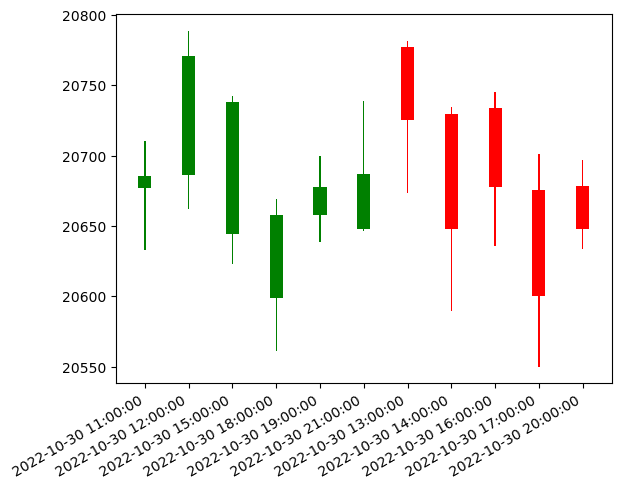

In [16]:
# DataFrame to represent opening , closing, high 
stock_prices = df_pandas
  
plt.figure()
  
up = stock_prices[stock_prices.close >= stock_prices.open]
  
down = stock_prices[stock_prices.close < stock_prices.open]
  
col1 = 'green'
  
col2 = 'red'
  
width = .3
width2 = .03
  
# Plotting up prices of the stock
plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
  
plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)
  
plt.xticks(rotation=30, ha='right')
  
plt.show()